In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)


Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [9]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [11]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

## CNN2 - LSTM1

In [12]:
# define model
model = Sequential()
model.add(Conv1D(filters = 256, kernel_size = 6, activation = 'relu', input_shape = (n_timesteps, n_features)))
model.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size = 2))

model.add(LSTM(150))

model.add(Dropout(0.5))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(n_outputs, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 123, 256)          14080     
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 128)          98432     
                                                                 
 dropout (Dropout)           (None, 121, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 150)               167400    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                        

In [13]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/20
58/58 [==============================] - 4s 18ms/step - loss: 0.7610 - accuracy: 0.6766 - val_loss: 0.4154 - val_accuracy: 0.8146
Epoch 2/20
58/58 [==============================] - 1s 13ms/step - loss: 0.3166 - accuracy: 0.8886 - val_loss: 0.1988 - val_accuracy: 0.9216
Epoch 3/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1675 - accuracy: 0.9404 - val_loss: 0.1720 - val_accuracy: 0.9456
Epoch 4/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1547 - accuracy: 0.9389 - val_loss: 0.1649 - val_accuracy: 0.9347
Epoch 5/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1366 - accuracy: 0.9457 - val_loss: 0.1180 - val_accuracy: 0.9519
Epoch 6/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1219 - accuracy: 0.9512 - val_loss: 0.1769 - val_accuracy: 0.9374
Epoch 7/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1142 - accuracy: 0.9517 - val_loss: 0.1038 - val_accuracy: 0.9592
Epoch 8/20
58

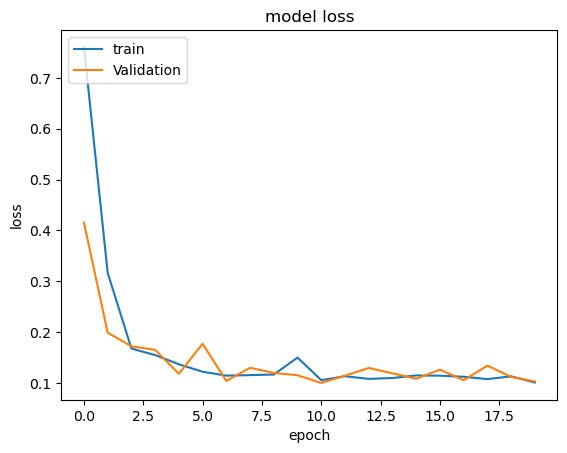

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

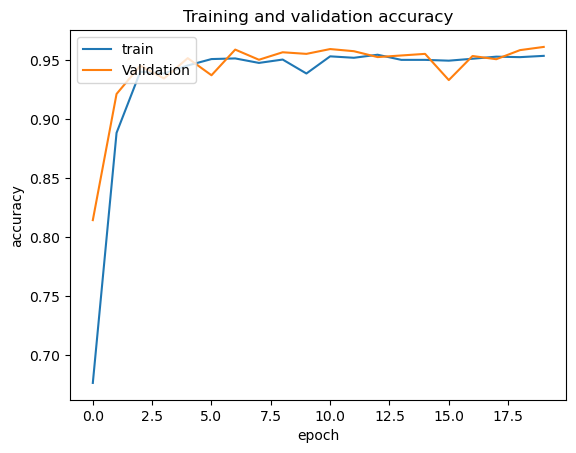

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 0s 3ms/step
[[474  11  11   0   0   0]
 [  0 446  25   0   0   0]
 [  0   1 419   0   0   0]
 [  0  19   0 409  57   6]
 [  1   1   0 108 422   0]
 [  0  17   0   0   0 520]]
0.9127926705123854
0.9125770569511298
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.90      0.95      0.92       471
           2       0.92      1.00      0.96       420
           3       0.79      0.83      0.81       491
           4       0.88      0.79      0.83       532
           5       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.92      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

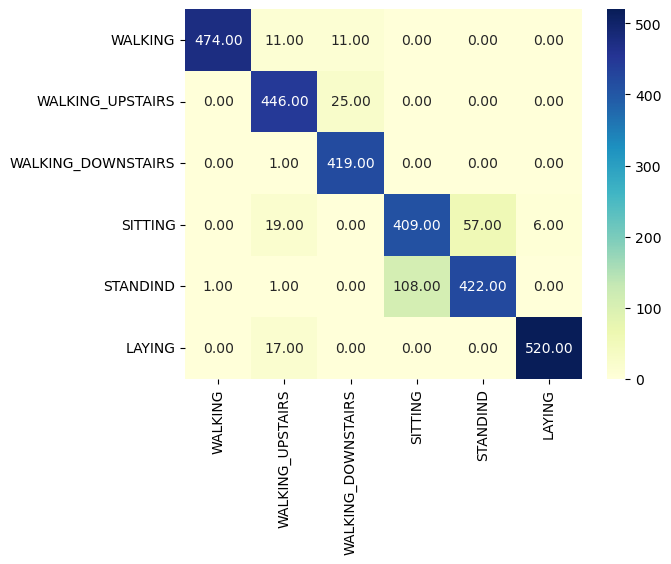

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')